<a href="https://colab.research.google.com/github/Muskanrathee725/Muskan/blob/main/Pneumonia_or_not_sing_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip
!unzip chest-xray-pneumonia.zip


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [2]:
import os

print("Train Normal images:", len(os.listdir("chest_xray/train/NORMAL")))
print("Train Pneumonia images:", len(os.listdir("chest_xray/train/PNEUMONIA")))

print("Test Normal images:", len(os.listdir("chest_xray/test/NORMAL")))
print("Test Pneumonia images:", len(os.listdir("chest_xray/test/PNEUMONIA")))


Train Normal images: 1341
Train Pneumonia images: 3875
Test Normal images: 234
Test Pneumonia images: 390


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [4]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"


In [5]:
# For training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # use 10% of train data for validation
)

# For validation and testing (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
batch_size = 32
img_size = (224, 224)  # as per MobileNetV2 input requirement

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # important for confusion matrix later
)


Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


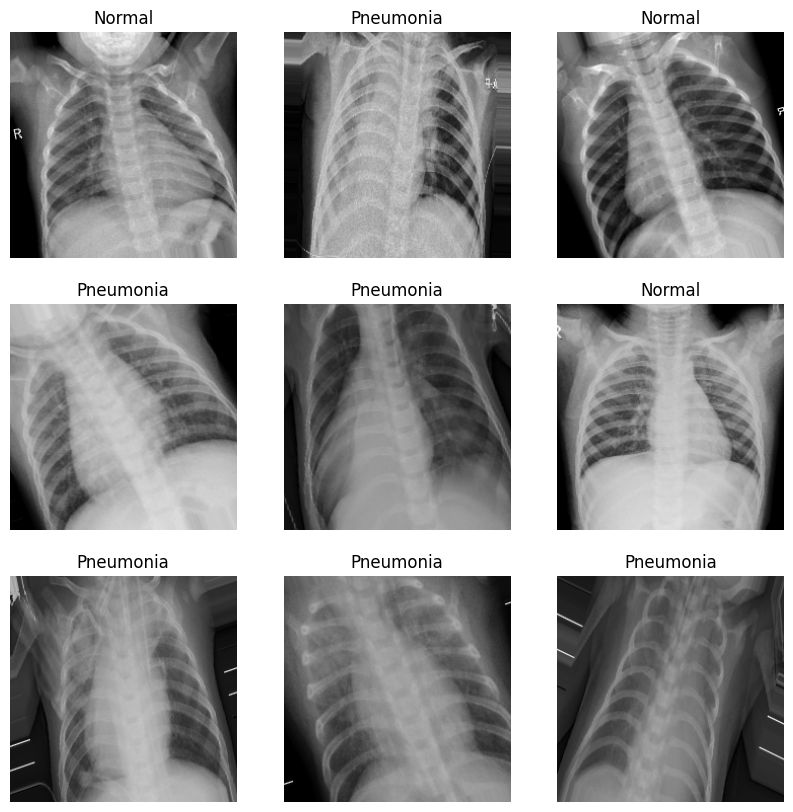

In [7]:
# Preview few images
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])
    plt.title('Pneumonia' if sample_labels[i] else 'Normal')
    plt.axis('off')
plt.show()


MobileNetV2: Pre-trained model (efficient, lightweight, good for medical datasets).

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers initially


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduces feature maps into a single vector
x = Dropout(0.3)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Binary classification (Pneumonia / Normal)

model = Model(inputs=base_model.input, outputs=output)


In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [13]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 123s 765ms/step - accuracy: 0.7696 - loss: 0.4772 - val_accuracy: 0.9213 - val_loss: 0.2177
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 97s 659ms/step - accuracy: 0.9099 - loss: 0.2166 - val_accuracy: 0.9309 - val_loss: 0.1771
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 96s 656ms/step - accuracy: 0.9243 - loss: 0.1798 - val_accuracy: 0.9347 - val_loss: 0.1668
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 113s 767ms/step - accuracy: 0.9306 - loss: 0.1697 - val_accuracy: 0.9309 - val_loss: 0.1743
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 126s 658ms/step - accuracy: 0.9376 - loss: 0.1510 - val_accuracy: 0.9463 - val_loss: 0.1398
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 95s 646ms/step - accuracy: 0.9492 - loss: 0.1339 - val_accuracy: 0.9309 - val_loss: 0.1503
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 95s 645ms/step - accuracy: 0.9418 - loss: 0.1437 - val_accuracy: 0.9194 - val_loss: 0.1760
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 96s 654ms/step - accuracy: 0.9485 - loss

In [14]:
base_model.trainable = True  # Unfreeze the base model

# Optional: Freeze first few layers to avoid overfitting small dataset
for layer in base_model.layers[:-30]:
    layer.trainable = False


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop]
)


Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 126s 754ms/step - accuracy: 0.9380 - loss: 0.1418 - val_accuracy: 0.9405 - val_loss: 0.1584
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 100s 682ms/step - accuracy: 0.9400 - loss: 0.1537 - val_accuracy: 0.9347 - val_loss: 0.1496
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 102s 698ms/step - accuracy: 0.9460 - loss: 0.1386 - val_accuracy: 0.9271 - val_loss: 0.1642
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 142s 698ms/step - accuracy: 0.9524 - loss: 0.1171 - val_accuracy: 0.9501 - val_loss: 0.1259
Epoch 5/5
 24/147 ━━━━━━━━━━━━━━━━━━━━ 1:20 654ms/step - accuracy: 0.9728 - loss: 0.0891

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [19]:
val_generator.reset()
pred_probs = model.predict(val_generator, verbose=1)
pred_classes = (pred_probs > 0.5).astype("int32").flatten()
true_classes = val_generator.classes


17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 754ms/step


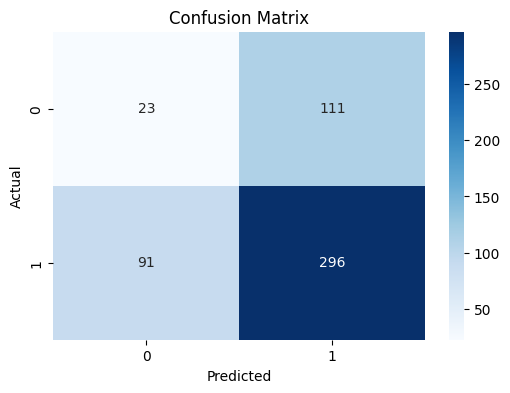

In [20]:
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [21]:
print(classification_report(true_classes, pred_classes, target_names=['Normal', 'Pneumonia']))


              precision    recall  f1-score   support

      Normal       0.20      0.17      0.19       134
   Pneumonia       0.73      0.76      0.75       387

    accuracy                           0.61       521
   macro avg       0.46      0.47      0.47       521
weighted avg       0.59      0.61      0.60       521



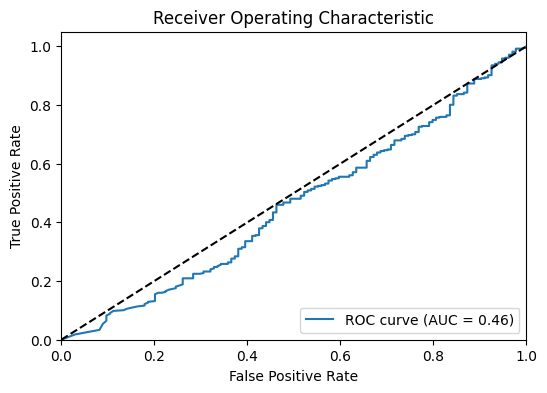

In [22]:
fpr, tpr, thresholds = roc_curve(true_classes, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
